# regression
## quantum neural networks experimentation

### index
1. [imports](#imports)
2. [data](#data)
3. [classical regression](#classical-regression)
4. [quantum regression](#quantum-regression)


### imports <a class="anchor" id="imports"></a>

In [8]:
# utils imports
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
# classical imports
from sklearn.neural_network import MLPRegressor
# quantum imports
from qiskit_algorithms.utils import algorithm_globals
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit import Parameter
from qiskit_algorithms.optimizers import L_BFGS_B
from qiskit.primitives import Estimator
from qiskit_machine_learning.algorithms.regressors import VQR

#constants
algorithm_globals.random_seed = 33
np.random.seed(33)


### data <a class="anchor" id="data"></a>

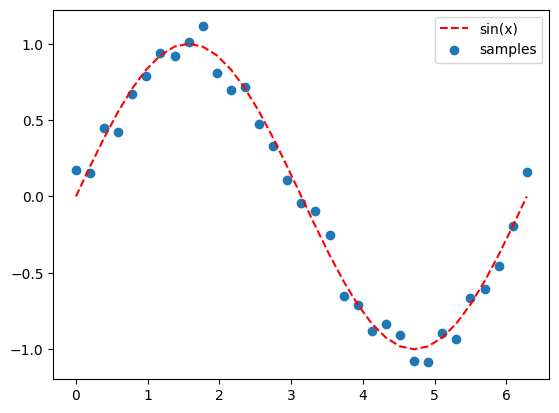

In [4]:
# we define the number of samples
n_samples = 33
x = np.linspace(0, 2 * np.pi, n_samples)
f = np.sin(x)
# we get random points from the function and add some noise
train_x = np.sort(np.random.choice(x, n_samples, replace=False))
train_y = f + 0.1 * np.random.randn(n_samples)
# we plot the function and the noisy samples
plt.plot(x, f, "r--", label="sin(x)")
plt.scatter(train_x, train_y, label="samples")
plt.legend()

### classical regression <a class="anchor" id="classical-regression"></a>

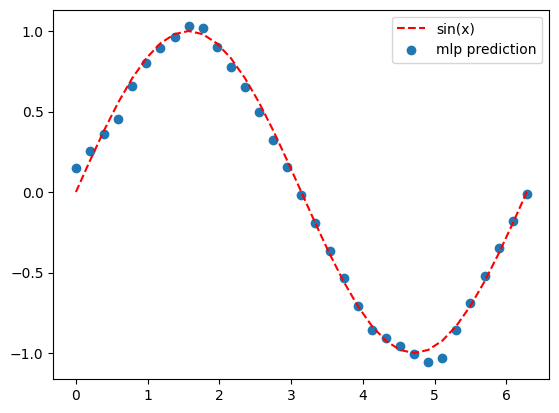

In [5]:
# we define a multilayer perceptron regressor with 2 hidden layers of 15 neurons each
mlp = MLPRegressor(solver="adam", learning_rate_init=0.01, hidden_layer_sizes =(15,15), random_state=33)
mlp.fit(train_x.reshape(-1,1), train_y)
# we plot the function and the noisy samples
plt.plot(x, f, "r--", label="sin(x)")
# we plot the prediction of the MLP regressor
plt.scatter(x, mlp.predict(x.reshape(-1,1)), label="mlp prediction")
plt.legend()

In [ ]:
# we evaluate the model accuracy
cl_train_score = mlp.score(x.reshape(-1,1), f)
print("classical accuracy: ", cl_train_score)


classical accuracy:  0.9964825160130562


### quantum regression <a class="anchor" id="quantum-regression"></a>

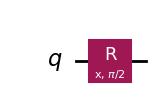

In [6]:
# we define a simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)
feature_map.decompose().draw(output="mpl", style="iqx")

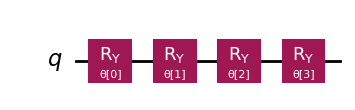

In [9]:
# we define a simple ansatz
ansatz = RealAmplitudes(1, reps=3)
ansatz.decompose().draw(output="mpl", style="iqx")

In [10]:
# we choose our optimizer algorithm
optimizer = L_BFGS_B(maxiter=10)

In [11]:
# we define where to train this model, in this case we will use a simulator
estimator = Estimator()

In [13]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("objective function value against iteration")
    plt.xlabel("iteration")
    plt.ylabel("objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

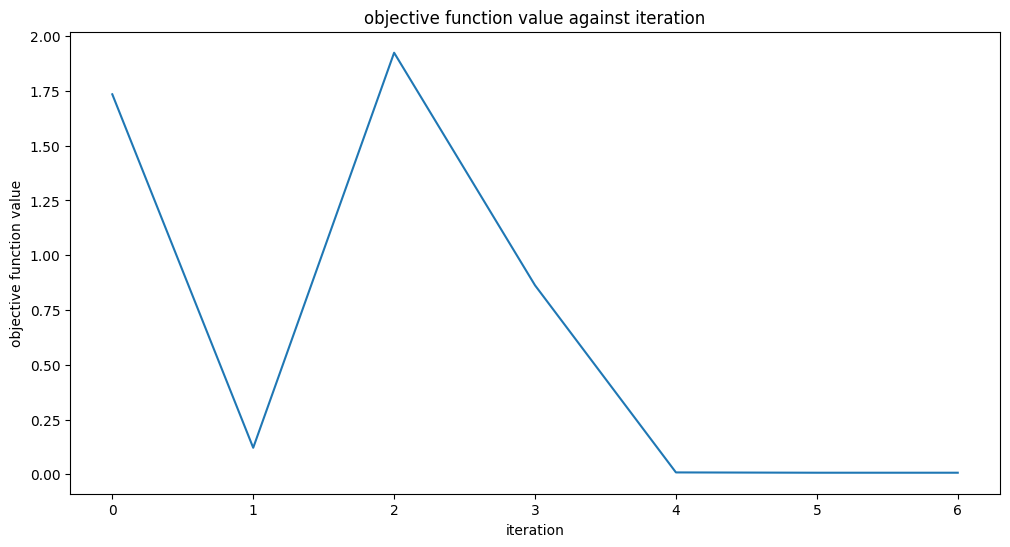

training time: 3.61 sec


In [15]:
objective_func_vals = []
# we define the variational quantum circuit
vqr = VQR(
    estimator=estimator,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)
start = time.time()
vqr.fit(train_x.reshape(-1,1), train_y)
end = time.time()
print(f"training time: {end-start:.2f} sec")

In [16]:
q_train_score = vqr.score(x.reshape(-1,1), f)

print(f"quantum accuracy: {q_train_score}")


quantum accuracy: 0.9998266549727008


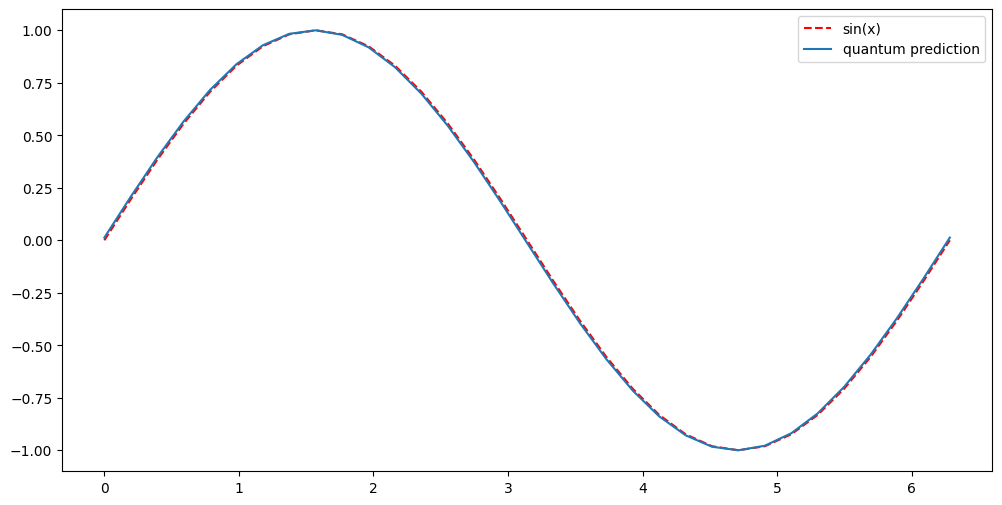

In [17]:
y_predict = vqr.predict(x.reshape(-1,1))
plt.plot(x, f, "r--", label="sin(x)")
plt.plot(x, y_predict, label="quantum prediction")
plt.legend()